# EE4211 Project

## Question 1

Group name:

Group members: Liu Tianshu, Nie Hongtuo, Pan Jie, Zhang Chenxi

### Question 1.1

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
df = pd.read_csv('dataport-export_gas_oct2015-mar2016.csv')

In [30]:
# turn to timestamp
def local2utc(time):
    return pd.Timestamp(time).tz_convert("UTC")
df.localminute = df.apply(lambda r: local2utc(r.localminute), axis=1)

First let's get the number of houses.

In [31]:
grouped = df.groupby(['dataid'])
len(grouped)

157

or

In [32]:
df.dataid.value_counts().size

157

In [36]:
print(df)

                             localminute  dataid  meter_value
0              2015-10-01 05:00:10+00:00     739        88858
1              2015-10-01 05:00:13+00:00    8890       197164
2              2015-10-01 05:00:20+00:00    6910       179118
3              2015-10-01 05:00:22+00:00    3635       151318
4              2015-10-01 05:00:22+00:00    1507       390354
...                                  ...     ...          ...
1584818 2016-04-01 04:59:14.336743+00:00    2129       201726
1584819 2016-04-01 04:59:17.427165+00:00    2945       161232
1584820 2016-04-01 04:59:35.370782+00:00    9729       138146
1584821 2016-04-01 04:59:47.816286+00:00    5129       166488
1584822 2016-04-01 04:59:58.923080+00:00     484       114174

[1584823 rows x 3 columns]


We have gas flow meters installed in 157 houses.
Now we can find the anomaly samples in the data.

In [33]:
def find_decrease(df):
    grouped = df.groupby(['dataid'])
    decrease_meter_id = []
    for key,group in grouped:
        val = group.meter_value.values
        diff = val[1:] - val[:-1]
        decrease_time_id = np.where(diff < 0)[0] + 1
        if len(decrease_time_id):
            decrease_meter_id.append(key)
            decrease_time = group.localminute.values[decrease_time_id]
            print('The glitches of gas meter No.', key, 'happened in the moments below:')
            print(decrease_time, '\n')
    return decrease_meter_id

In [34]:
defect_id = find_decrease(df)

In [35]:
print('The ID of the', len(defect_id), 'defective meters are:')
print(defect_id)

The ID of the 0 defective meters are:
[]


43 gas meters have sent values that decreased at some point.
Let's look inside the data series given by a defective meter, for example, gas meter No. 9982.

In [8]:
def plot_group(key,df):
    grouped = df.groupby(['dataid'])
    group = grouped.get_group(key)
    t = group.localminute.values
    val = group.meter_value.values

    s = pd.Series(val, index=t)
    s.plot(figsize=(16, 8))
    plt.xticks(rotation=-20)
    plt.title('Gas Meter No.' + str(key))
    return

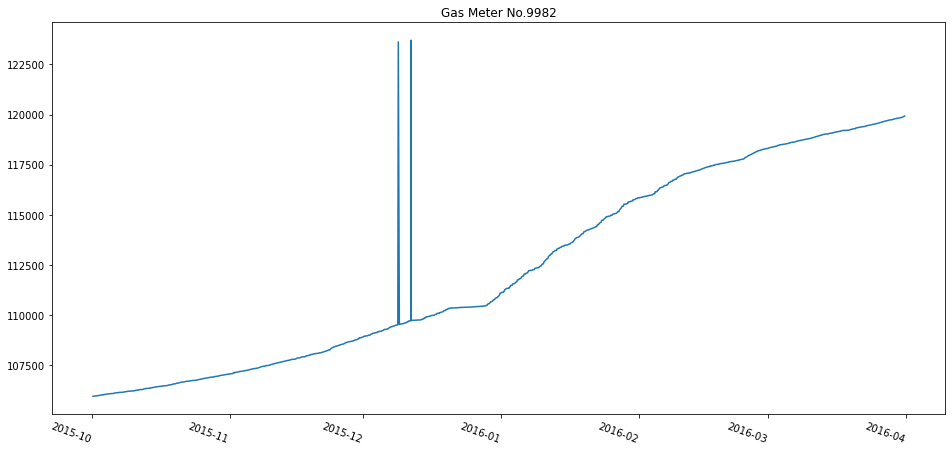

In [9]:
plot_group(9982,df)

### Question 1.2

#### Data Preprocessing

Since there are glitches in some of the data series, we need to smooth the data first.
There are 2 kinds of glitches: sudden increase and slight decrease, both of which are shown below. The slight decrease can be hard to spot for human eyes, but can be seen in the printed data samples below the figure. We will replace the impulses and fluctuations with the last available values before them.

Note that we decided not to take summer time into consideration, since time zone will not affect the way how people consume the gas. A family that usually cook at 7 pm will still cook at 7 no matter summer time is used or not.

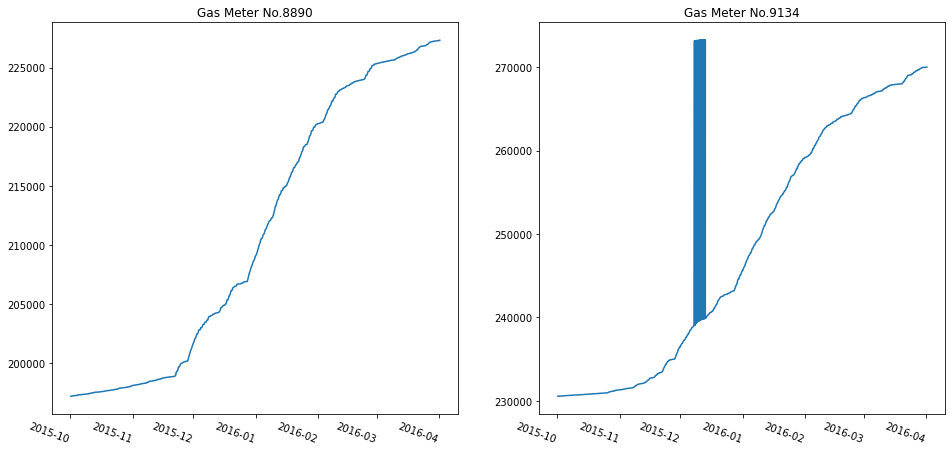

In [10]:
plt.subplot(121)
plot_group(8890,df)

plt.subplot(122)
plot_group(9134,df)

Here are the data samples before and after the time when glitches happened. All values under each **ID** is smaller than those under **ID - 1**.

In [11]:
def find_decrease_details(df):
    decrease_details = []
    grouped = df.groupby(['dataid'])
    for key,group in grouped:
        val = group.meter_value.values
        diff = val[1:] - val[:-1]
        decrease_time_id = np.where(diff < 0)[0] + 1
        if len(decrease_time_id):
            for id in decrease_time_id:
                decrease_details.append([key, id, val[id-3], val[id-2], val[id-1], val[id], val[id+1]])

    labels = ['Gas Meter ID', 'Sample ID', 'ID - 3','ID - 2', 'ID - 1', 'ID + 0', 'ID + 1']
    decrease_details_df = pd.DataFrame(decrease_details, columns=labels)
    pd.set_option('display.max_rows', None)
    print(decrease_details_df)
    pd.set_option('display.max_rows', 15)
    return

In [12]:
find_decrease_details(df)

      Gas Meter ID  Sample ID  ID - 3  ID - 2  ID - 1  ID + 0  ID + 1
0               35        958   93998   93998   94014   94012   94014
1               77       1518   59254   59254   59260   59258   59262
2               94       7380  117626  117626  117626  117614  117626
3               94       7383  117614  117626  117626  117614  117626
4               94       7385  117626  117614  117626  117616  117620
5               94      22298  129598  129602  129602  129598  129598
6               94      22712  130306  130306  130316  130306  130306
7               94      22716  130306  130306  130316  130310  130316
8              483       2590  361130  361140  361144  361130  361144
9              484       7496  100416  100418  100418  100416  100416
10             484       7500  100416  100416  100418  100416  100418
11             484       7502  100418  100416  100418  100416  100418
12             484       7504  100418  100416  100418  100416  100418
13             484  

Now let's get the data prettier.

In [13]:
def rectify(df):
    grouped = df.groupby(['dataid'])
    for key,group in grouped:
        val = group.meter_value.values
        diff = val[1:] - val[:-1]
        defect_time = np.where(diff < 0)[0] + 1
        if len(defect_time):
            for i in range(1,len(val)):
                if val[i] > val[-1]:
                    val[i] = val[i - 1]
                elif val[i] < val[i - 1]:
                    val[i] = val[i - 1]
            df.loc[df['dataid'] == key, 'meter_value'] = val
    return df

In [14]:
df = rectify(df)

Then we can recheck if there are any decreasing data samples in our dataset.

In [15]:
defect_id = find_decrease(df)
len(defect_id)

0

There isn't any decreasing anymore! We can see the difference from the two figures below.

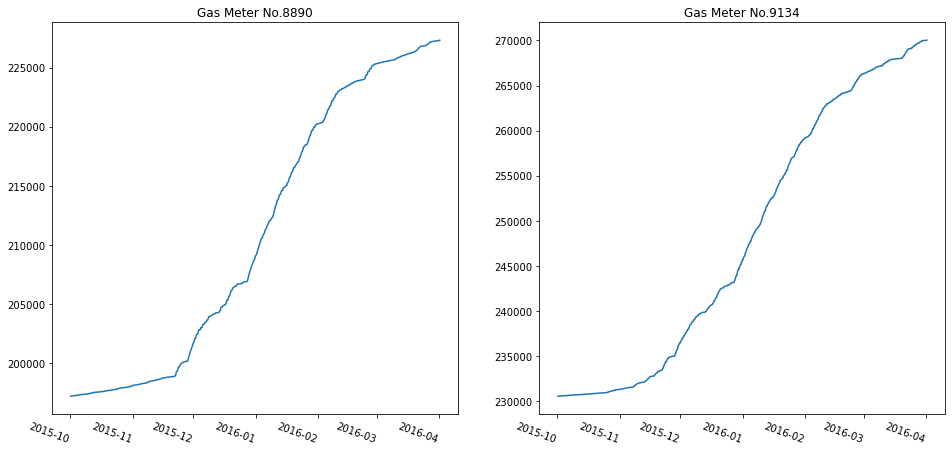

In [16]:
plt.subplot(121)
plot_group(8890,df)

plt.subplot(122)
plot_group(9134,df)

#### Grouping by Month

In [17]:
import datetime
def local2utc(time):
    return pd.Timestamp(time).tz_convert("UTC")
def select_data(df, month) -> pd.DataFrame:
    column_names = df.columns.values
    values = df.values
    values = filter(lambda x: x[0].month == month, values)
    values = pd.DataFrame(values)
    for i in range(len(column_names)):
        values = values.rename(columns={i:column_names[i]})
    return values

In [18]:
## select Oct data
month_data = select_data(df, 10)
print(month_data)

                     localminute  dataid  meter_value
0      2015-10-01 05:00:10+00:00     739        88858
1      2015-10-01 05:00:13+00:00    8890       197164
2      2015-10-01 05:00:20+00:00    6910       179118
3      2015-10-01 05:00:22+00:00    3635       151318
4      2015-10-01 05:00:22+00:00    1507       390354
...                          ...     ...          ...
264599 2015-10-31 23:59:16+00:00    8890       198088
264600 2015-10-31 23:59:30+00:00    4029       301098
264601 2015-10-31 23:59:36+00:00    2034        73030
264602 2015-10-31 23:59:46+00:00    5439       181558
264603 2015-10-31 23:59:51+00:00    5814       803408

[264604 rows x 3 columns]


In [19]:
def hourly_data_by_group(df) -> set():
    groups = df.groupby(['dataid'], sort=['localminute'])
    processed_group = {}
    for key in groups.groups.keys():
        new_group = []
        current_group = groups.get_group(key).values
        # init_first_point
        first_point = current_group[0]
        first_point[0] = first_point[0].replace(day = 1, hour = 0, minute = 0, second = 0)
        index_current_group = 0
        tmp = []
        # replace all time on the hour
        for row in current_group:
            row[0] = row[0].replace(minute = 0, second = 0)
            tmp.append(row)
        current_group = tmp
        # interpolate data 24 hour for 30 day
        for day in range(1, 31):
            for hour in range(0, 24):
                # make sure its the last data of the current time
                while (True):
                    if (index_current_group >= len(current_group)):
                        break
                    current_row = current_group[index_current_group]
                    time = current_row[0]
                    if (time.day == day and time.hour == hour):
                        index_current_group += 1
                    else:
                        break
                # assign data
                current_row = current_group[index_current_group - 1]
                time = current_row[0]
                date = pd.Timestamp(year = time.year, month = time.month, day = time.day, hour = time.hour, minute = 0, second = 0)
                current_row = [date, current_row[1], current_row[2]]
                if (time.day == day and time.hour == hour):
                    if (len(new_group) > 0 and new_group[-1][0].day == day and new_group[-1][0].hour == hour):
                        new_group[-1] = current_row
                    else:
                        new_group.append(current_row)
                else:
                    date = pd.Timestamp(year = time.year, month = time.month, day = day, hour = hour, minute = 0, second = 0)
                    row = [date,new_group[-1][1],new_group[-1][2]]
                    new_group.append(row)
        processed_group[key] = new_group
    return processed_group

In [20]:
hourly_data_groups = hourly_data_by_group(month_data)

In [21]:
print('Meter IDs from 157 houses:\n', hourly_data_groups.keys(), '\n')

Meter IDs from 157 houses:
 dict_keys([35, 44, 77, 94, 114, 187, 222, 252, 370, 483, 484, 661, 739, 744, 871, 1042, 1086, 1103, 1185, 1283, 1415, 1507, 1556, 1589, 1619, 1697, 1714, 1718, 1790, 1791, 1792, 1800, 1801, 2018, 2034, 2072, 2094, 2129, 2233, 2335, 2378, 2449, 2461, 2470, 2575, 2638, 2645, 2818, 2945, 2965, 2980, 3039, 3134, 3310, 3367, 3527, 3544, 3577, 3635, 3723, 3778, 3849, 3893, 3918, 4029, 4031, 4193, 4228, 4296, 4352, 4356, 4373, 4421, 4447, 4514, 4671, 4732, 4767, 4998, 5129, 5131, 5193, 5275, 5395, 5403, 5439, 5484, 5636, 5785, 5810, 5814, 5892, 5972, 6412, 6505, 6578, 6685, 6830, 6836, 6863, 6910, 7016, 7017, 7030, 7117, 7287, 7429, 7460, 7674, 7682, 7739, 7741, 7794, 7900, 7919, 7965, 7989, 8059, 8084, 8086, 8155, 8156, 8386, 8467, 8703, 8829, 8890, 8967, 9052, 9121, 9134, 9278, 9295, 9474, 9620, 9631, 9639, 9729, 9766, 9849, 9956, 9982]) 



In [25]:
def to_data_frame(data_list):
    labels = ['localminute', 'dataid', 'meter_value']
    df = pd.DataFrame(data_list, columns=labels)
    return df

#for i in hourly_data_groups[35]:
#    print(i)



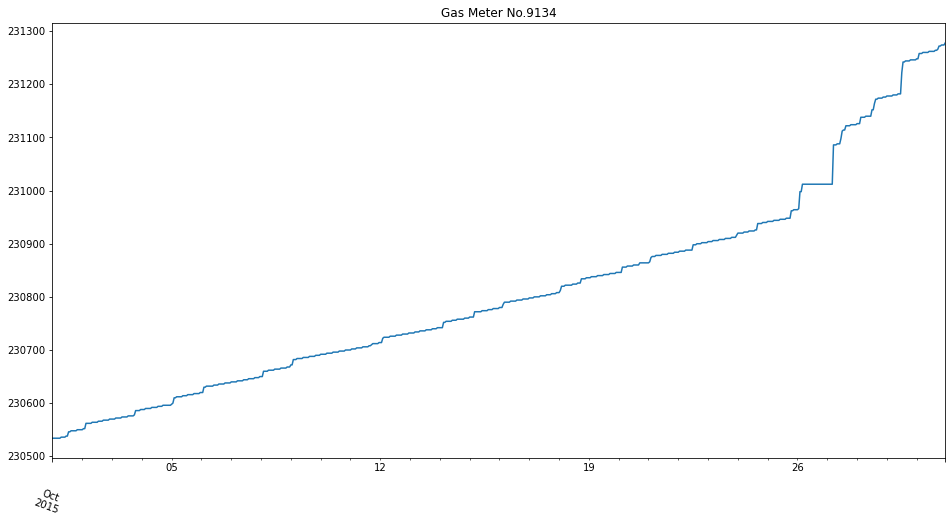

In [28]:
key = 9134
month_df = to_data_frame(hourly_data_groups[key])
plot_group(key,month_df)